# Data exploration

In this notebook, we review the dataset to understand what the data represent and the relationship between data elements. This also includes dealing with the null values and defining the preprocessing function.


### Import statements

In [486]:
pip install --upgrade seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 23.3.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [487]:
# Import statements 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

### 1° Loading the dataset

In [467]:
filepath = '../../RFQ_Data_Challenge_HEC.csv'
df = pd.read_csv(filepath)
df.head()

/var/folders/h7/_dgsjjs93hv7lr5ql2ffz2_c0000gn/T/ipykernel_71306/1895652701.py:2: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


,Deal_Date,ISIN,cusip,Instrument,Sales_Name,Sales_Initial,company_short_name,B_Price,B_Side,Total_Requested_Volume,...,MidYTM,YTWDate,SpreadvsBenchmarkMid,MidASWSpread,MidZSpread,GSpreadMid,MidModifiedDuration,MidConvexity,MidEffectiveDuration,MidEffectiveConvexity
0,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 25/2/2025 2.500,Blanca Tailpied,BLA,Bnp Reunion,0.0,NATIXIS SELL,77551,...,5.57551,NaN,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874
1,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 25/2/2025 2.500,Blanca Tailpied,BLA,Cegi Ett,0.0,NATIXIS SELL,8163,...,5.57551,NaN,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874
2,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 25/2/2025 2.500,Blanca Tailpied,BLA,Qbe,0.0,NATIXIS SELL,20408,...,5.57551,NaN,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874
3,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 2.5% 25 FEB 2025,Blanca Tailpied,BLA,Cegi Ett,0.0,NATIXIS SELL,16327,...,5.57551,NaN,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874
4,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 2.5% 25 FEB 2025,Constantin Durie,CON,Scp Laureau-Jeannerot,0.0,NATIXIS SELL,244898,...,5.57551,NaN,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874


In [488]:
df.ISIN.value_counts()

ISIN
IT0003934657    8582
IT0005441883    4595
IT0005425233    4396
FR0014001NN8    4320
IT0005518128    4191
                ... 
USU2920CAA19       1
XS1637404275       1
XS2078642183       1
US91282CEX56       1
DE000SHFM683       1
Name: count, Length: 9635, dtype: int64

In [489]:
df.maturity

0         2025-02-25 00:00:00.000
1         2025-02-25 00:00:00.000
2         2025-02-25 00:00:00.000
3         2025-02-25 00:00:00.000
4         2025-02-25 00:00:00.000
                   ...           
635450    2026-04-13 00:00:00.000
635451    2025-01-31 00:00:00.000
635452    2024-07-05 00:00:00.000
635453                       EMEA
635454                     FRANCE
Name: maturity, Length: 635455, dtype: object

In [490]:
df.Maturity

0         02/25/2025 00:00:00
1         02/25/2025 00:00:00
2         02/25/2025 00:00:00
3         02/25/2025 00:00:00
4         02/25/2025 00:00:00
                 ...         
635450    04/13/2027 00:00:00
635451    01/31/2025 00:00:00
635452    10/05/2024 00:00:00
635453    03/21/2082 00:00:00
635454    11/28/2025 00:00:00
Name: Maturity, Length: 635455, dtype: object

### 2° Defining the preprocessing function

In [491]:
df.columns

Index(['Deal_Date', 'ISIN', 'cusip', 'Instrument', 'Sales_Name',
       'Sales_Initial', 'company_short_name', 'B_Price', 'B_Side',
       'Total_Requested_Volume', 'Total_Traded_Volume_Natixis',
       'Total_Traded_Volume_Away', 'Total_Traded_Volume',
       'BloomIndustrySector', 'BloomIndustryGroup', 'BloomIndustrySubGroup',
       'cdcissuerShortName', 'cdcissuer', 'Country', 'lb_Platform_2',
       'maturity', 'Rating_Fitch', 'Rating_Moodys', 'Rating_SP', 'Cusip',
       'Ccy', 'Classification', 'Tier', 'Maturity', 'AssumedMaturity',
       'Coupon', 'Frequency', 'Type', 'MidPrice', 'MidYTM', 'YTWDate',
       'SpreadvsBenchmarkMid', 'MidASWSpread', 'MidZSpread', 'GSpreadMid',
       'MidModifiedDuration', 'MidConvexity', 'MidEffectiveDuration',
       'MidEffectiveConvexity'],
      dtype='object')

In [492]:
df.dtypes

Deal_Date                       object
ISIN                            object
cusip                           object
Instrument                      object
Sales_Name                      object
Sales_Initial                   object
company_short_name              object
B_Price                         object
B_Side                          object
Total_Requested_Volume          object
Total_Traded_Volume_Natixis    float64
Total_Traded_Volume_Away       float64
Total_Traded_Volume            float64
BloomIndustrySector             object
BloomIndustryGroup              object
BloomIndustrySubGroup           object
cdcissuerShortName              object
cdcissuer                       object
Country                         object
lb_Platform_2                   object
maturity                        object
Rating_Fitch                    object
Rating_Moodys                   object
Rating_SP                       object
Cusip                           object
Ccy                      

Insights on some features :
- **Deal_Date** : The date on which a financial deal is executed. Needs to be converteted in datetime.
- **ISIN** : International Securities Identification Number, a unique identifier for Financial instruments.
- **company_short_name** : the name of the issuer of the financial instrument. It corresponds to the client name.
- **B_price** : The bid price of the financial instrument. To be converted to int (object for the moment)
- **B_side** : Natixis's position as a buyer or seller of the financial instrument (for the moment 'NATIXIS SELL' or 'NATIXIS BUY'). Contient 8 valeurs nulles.
- **Total_Requested_Volume** : The requested volume for buying or selling the financial instrument. It needs to be converted into a numerical column (object for the moment). Contient 2 valeurs nulles.
- **Total_Traded_Volume_Natixis** : The volume of the financial instrument traded by Natixis. Already good data type.
- **Total_Traded_Volume_Away** : The volume of the financial instrument traded by other banks. Already good data type.
- **Total_Traded_Volume** : The total volume of the financial instrument traded. Already good data type.
- **BloomIndustrySector**, **BloomIndustryGroup**,**BloomIndustrySubGroup**
- **maturity** : The length of time during which interest is paid. Some null values are marked as NaT. We convert this column into Datetime type. Some maturities go back to 1900, it is not possible. We delete those.
- **Rating_Fitch** : The credit rating of the financial instrument from Fitch Ratings.
- **Rating_Moodys** : The credit rating of the financial instrument from Moody's.
- **Rating_SP** : The credit rating of the financial instrument from S&P Global Ratings.
- **Ccy** : The currency in which the financial instrument is denominated.
- **Classification** : The activity sector of the company.
- **Tier** : The seniority level of the financial instrument. Lots of null value, we replace them by UNKOWN (627100 values)
- **AssumedMaturity** : The assumed maturity date of the financial instrument. Also contains a lot of null values, we replace them by maturity values (the null values only).
- **Coupon** : The interest rate of the financial instrument. Already a float.
- **Frequency** : The frequency of interest payments on the financial instrument. Takes values 1M, 3M, 6M, 12M. We delete the 'M' and convert the value into int.
- **Type** : The type of interest rate on the financial instrument (fixed or variable).
- **MidYTM** : The yield to maturity on the prime bid. Already a float.
- **MidYTM** : The yield to maturity on the prime bid. Already a float.
- **YTWDate** : Yield to Worst - The yield on the first possible redemption date. 
- **SpreadvsBenchmarkMid** : The spread of the financial instrument versus the interpolated government bond curve.
- **MidASWSpread** : The spread of the financial instrument versus the swap curve.
- **MidZSpread** : The spread of the financial instrument versus the zero- coupon curve.
- **GSpreadMid** : The spread of the financial instrument versus the interpolated government bond curve.
- **MidModifiedDuration** : The modified duration of the financial instrument. 
- **MidConvexity** : The convexity of the financial instrument.
- **MidEffectiveDuration** : The effective duration of the financial instrument.
- **MidEffectiveConvexity** : The effective convexity of the financial instrument.

Features that can be deleted at first : 
- **Cusip**, same as **cusip** but with more null values 
- **Maturity**, same as **maturity**

Added columns :
- Year, month, day of deal_date
- Year, month, day of maturity
- days to maturity

In [493]:
# Null values analysis for columns with null values below 15000
below_threshold = df.isnull().sum().sort_values(ascending=False) < 15000
print("Columns with null values below 15000:")
print(below_threshold[below_threshold].index)

# Null values analysis for columns with null values above 15000
above_threshold = df.isnull().sum().sort_values(ascending=False) >= 15000
print("\nColumns with null values above or equal to 15000:")
print(above_threshold[above_threshold].index)


Columns with null values below 15000:
Index(['Sales_Initial', 'Sales_Name', 'MidYTM', 'Coupon', 'Ccy',
       'BloomIndustryGroup', 'BloomIndustrySector', 'Instrument', 'cusip',
       'maturity', 'cdcissuerShortName', 'Frequency', 'MidPrice', 'cdcissuer',
       'company_short_name', 'BloomIndustrySubGroup', 'B_Price',
       'Classification', 'Total_Traded_Volume_Natixis', 'B_Side',
       'Total_Traded_Volume_Away', 'Total_Requested_Volume',
       'Total_Traded_Volume', 'Type', 'Maturity', 'ISIN', 'Deal_Date'],
      dtype='object')

Columns with null values above or equal to 15000:
Index(['Tier', 'AssumedMaturity', 'YTWDate', 'GSpreadMid',
       'SpreadvsBenchmarkMid', 'Cusip', 'MidEffectiveConvexity',
       'MidEffectiveDuration', 'MidASWSpread', 'Rating_Moodys', 'MidConvexity',
       'Rating_Fitch', 'MidZSpread', 'Rating_SP', 'MidModifiedDuration',
       'Country', 'lb_Platform_2'],
      dtype='object')


In [499]:
def preprocess_dataframe(df):
    """
    Preprocesses the input DataFrame with the following steps:
    1. Converts 'Deal_Date', 'maturity', 'AssumedMaturity', 'YTWDate' columns to datetime.
    2. Converts 'B_Side' column to boolean (1 for 'NATIXIS BUY', 0 for 'NATIXIS SELL').
    3. Converts 'B_Price' and 'Total_Requested_Volume' columns to integers.
    4. Fills null values in 'Tier', 'AssumedMaturity', and 'YTWDate' columns with 'UNKNOWN'.
    5. Converts 'Frequency' feature values into integers (removing 'M' from the end).
    6. Drops the unsused 'Cusip' column.

    Parameters:
    - df (DataFrame): Input DataFrame.

    Returns:
    - DataFrame: Processed DataFrame.
    """

    df = df.copy()

    # Drop null values only for columns below the threshold
    columns_to_delete_null_vales = ['MidYTM', 'Coupon', 'Ccy', 'cusip',
       'maturity', 'cdcissuerShortName', 'Frequency', 'MidPrice', 'cdcissuer',
       'company_short_name', 'BloomIndustrySubGroup', 'B_Price',
       'Total_Traded_Volume_Natixis', 'B_Side',
       'Total_Traded_Volume_Away', 'Total_Requested_Volume',
       'Total_Traded_Volume', 'Type', 'Maturity', 'ISIN', 'Deal_Date']
    df = df.dropna(subset=columns_to_delete_null_vales)

    # Convert 'B_Price', 'Total_Requested_Volume', 'Frequency' to integers
    df['Frequency'] = df['Frequency'].str.replace('M', '')
    numerical_columns = ['B_Price', 'Total_Requested_Volume', 'Frequency']
    df.dropna(subset=numerical_columns, inplace=True)
    for column in numerical_columns:
        df[column] = pd.to_numeric(df[column], errors='coerce').astype(int)

    # Fix the error in the B_Price column
    df = df[df['B_Price'] >= 20]

    # Replace NaT with null values in the 'Maturity' column
    df['maturity'].replace({pd.NaT: np.nan}, inplace=True)

    # Convert 'Deal_Date', 'maturity', 'AssumedMaturity', 'YTWDate' to datetime
    df['Deal_Date'] = pd.to_datetime(df['Deal_Date'])
    df['maturity'] = pd.to_datetime(df['maturity'], errors='coerce',  format='%Y-%m-%d %H:%M:%S.%f')
    df['AssumedMaturity'] = pd.to_datetime(df['AssumedMaturity'], errors='coerce')
    df['YTWDate'] = pd.to_datetime(df['YTWDate'], errors='coerce')

    # Add year, month, day for clustering 
    df['Year_dealdate'] = df['Deal_Date'].dt.year
    df['Month_dealdate'] = df['Deal_Date'].dt.month
    df['Day_dealdate'] = df['Deal_Date'].dt.day
    df['Year_maturity'] = df['maturity'].dt.year
    df['Month_maturity'] = df['maturity'].dt.month
    df['Day_maturity'] = df['maturity'].dt.day

    # Delete maturities smaller than 2021 (as deal dates starts in 2021)
    df = df[df['maturity'].dt.year >= 2021]

    # Compute number of days between maturity and deal date
    df['Days_to_Maturity'] = (df['maturity'] - df['Deal_Date']).dt.days

    # Replace null values in 'AssumedMaturity' with values from 'Maturity'
    df['AssumedMaturity'] = df['AssumedMaturity'].fillna(df['Maturity'])

    # Convert 'B_Side' column to boolean (1 for 'NATIXIS BUY', 0 for 'NATIXIS SELL')
    df = df[df['B_Side'].isin(['NATIXIS SELL', 'NATIXIS BUY'])]
    df['B_Side'] = df['B_Side'].replace({'NATIXIS BUY': 1, 'NATIXIS SELL': 0})

    # Convert null values of 'Tier'
    df['Tier'].fillna('UNKNOWN', inplace=True)

    # Lower string names 
    df['Sales_Name'] = df['Sales_Name'].str.lower()
    df['company_short_name'] = df['company_short_name'].str.lower()

    # Drop unused columns
    columns_to_drop = ['Cusip', 'Maturity']
    df.drop(columns=columns_to_drop, inplace=True)

    return df

In [500]:
df_preprocessed = preprocess_dataframe(df)
df_preprocessed.head()

,Deal_Date,ISIN,cusip,Instrument,Sales_Name,Sales_Initial,company_short_name,B_Price,B_Side,Total_Requested_Volume,...,MidConvexity,MidEffectiveDuration,MidEffectiveConvexity,Year_dealdate,Month_dealdate,Day_dealdate,Year_maturity,Month_maturity,Day_maturity,Days_to_Maturity
6,2022-11-10,NL0011220108,EK8199722,NETHER 0.25% 15 JUL 2025,heddy kerneves,HED,banque populaire de l'ouest,95,1,13061,...,10.181840,2.47743,8.883440,2022,11,10,2025.0,7.0,15.0,978
7,2022-11-10,NL0011220108,EK8199722,NETHER 0.25% 15 JUL 2025,ian prechais,IAN,license de transport,95,0,136,...,10.181840,2.47743,8.883440,2022,11,10,2025.0,7.0,15.0,978
8,2022-11-10,NL0011220108,EK8199722,NETHER 0.25% 15 JUL 2025,ian prechais,IAN,bp val de france,95,0,1224490,...,10.181840,2.47743,8.883440,2022,11,10,2025.0,7.0,15.0,978
9,2022-11-10,NL0011220108,EK8199722,NETHER 0.25% 15 JUL 2025,elisene arslane,ELI,hsbc,95,0,91837,...,10.181840,2.47743,8.883440,2022,11,10,2025.0,7.0,15.0,978
12,2023-10-18,IT0005530032,ZM3378175,BTPS 4.45% 01 SEP 2043,ian prechais,IAN,societe generale mer,92,0,2041,...,212.362656,11.40296,192.445251,2023,10,18,2043.0,9.0,1.0,7258


In [501]:
df_preprocessed.shape

(314718, 49)

Once we've corrected the B_price error, which sometimes corresponds to yield values (by setting a minimum value of 20), only 314718 lines remain.

### 3° Quick EDA

In [502]:
# Print null values
df_preprocessed.isnull().sum().sort_values(ascending=False)

YTWDate                        308252
GSpreadMid                     231918
SpreadvsBenchmarkMid           229476
lb_Platform_2                    7555
Country                          7555
MidASWSpread                     7206
Rating_SP                        4473
Rating_Fitch                     4462
Rating_Moodys                    3233
MidEffectiveConvexity            2413
MidEffectiveDuration             2409
MidConvexity                     1756
MidZSpread                       1588
MidModifiedDuration              1389
Sales_Initial                     888
Sales_Name                        888
Instrument                        788
BloomIndustrySector                33
BloomIndustryGroup                 33
Classification                      2
MidYTM                              0
Deal_Date                           0
Type                                0
Year_dealdate                       0
Month_dealdate                      0
Day_dealdate                        0
Year_maturit

We remark that some columns have more than 50% null values : YTWDate, GSpreadMid, SpreadvsBenchmarkMid.

In [503]:
df_government = df_preprocessed[df_preprocessed['BloomIndustrySector']=='Government'].copy()
df_government = df_government[['YTWDate', 'SpreadvsBenchmarkMid', 'GSpreadMid']]
print('Number of government bonds : ', df_government.shape[0])
print('Null values in government bonds : ')
print(df_government.isnull().sum().sort_values(ascending=False))

Number of government bonds :  289588
Null values in government bonds : 
YTWDate                 289570
SpreadvsBenchmarkMid    229464
GSpreadMid              229285
dtype: int64


Of the zero values in the YTWDate column, almost 100% correspond to government bonds. One possible reason is that government bonds can be issued without an early redemption clause, meaning that there is no date on which the issuer can redeem the bond before maturity. In this case, the YTWDate column would have no significant value and could be left blank.

A. **Deal_Date analysis**

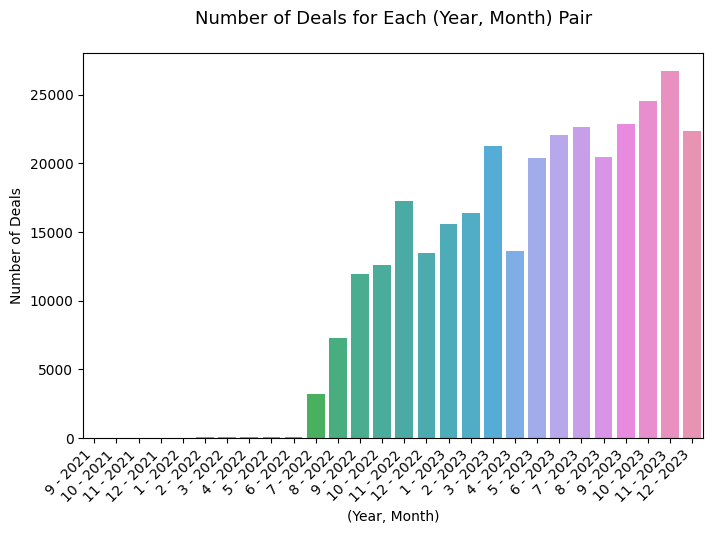

In [504]:
# Extract year and month from 'Deal_Date'
counts_df = df_preprocessed.groupby(['Year_dealdate', 'Month_dealdate']).size().reset_index(name='Counts')
counts_df['Month_Year_dealdate'] = counts_df['Month_dealdate'].astype(str) + ' - ' + counts_df['Year_dealdate'].astype(str)

# Plot the histogram
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Month_Year_dealdate', y='Counts', data=counts_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Number of Deals for Each (Year, Month) Pair\n', fontsize=13)
plt.xlabel('(Year, Month)')
plt.ylabel('Number of Deals')
plt.show()

A. **maturity analysis**

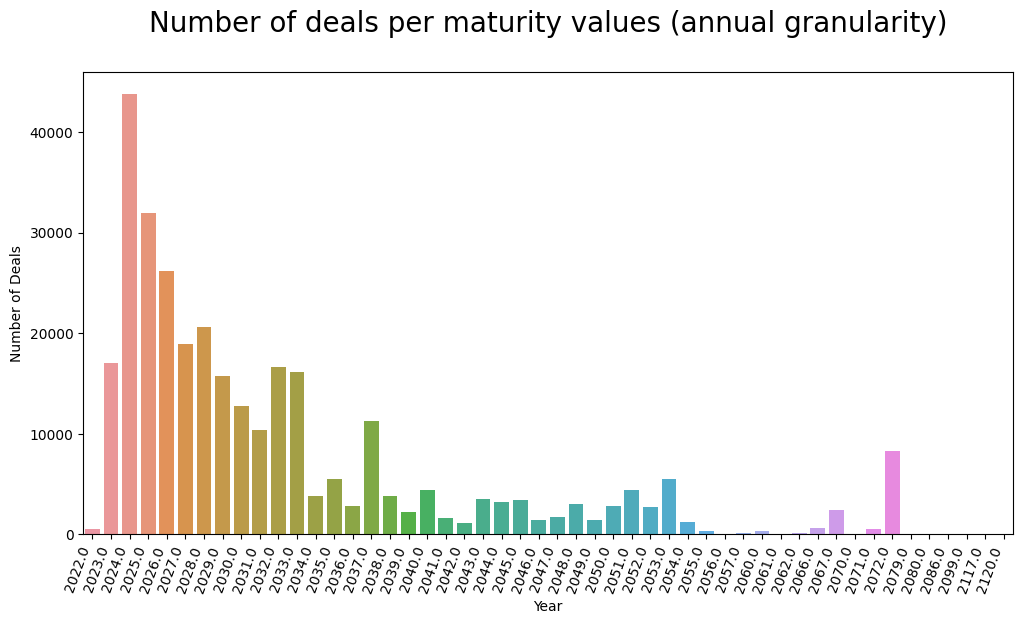

In [505]:
df_maturity = df_preprocessed.dropna(subset=['maturity'], inplace=False)
df_maturity = df_maturity.groupby('Year_maturity').size().reset_index(name='Counts')
df_maturity.sort_values(by='Year_maturity', ascending=True)


# Plot the histogram
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Year_maturity', y='Counts', data=df_maturity)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
plt.title('Number of deals per maturity values (annual granularity)\n', fontsize=20)
plt.xlabel('Year')
plt.ylabel('Number of Deals')
plt.show()

C. **company_short_name analysis**

In [506]:
number_of_comp = len(df_preprocessed.company_short_name.values)
print("Number of companies : ", number_of_comp)

Number of companies :  314718


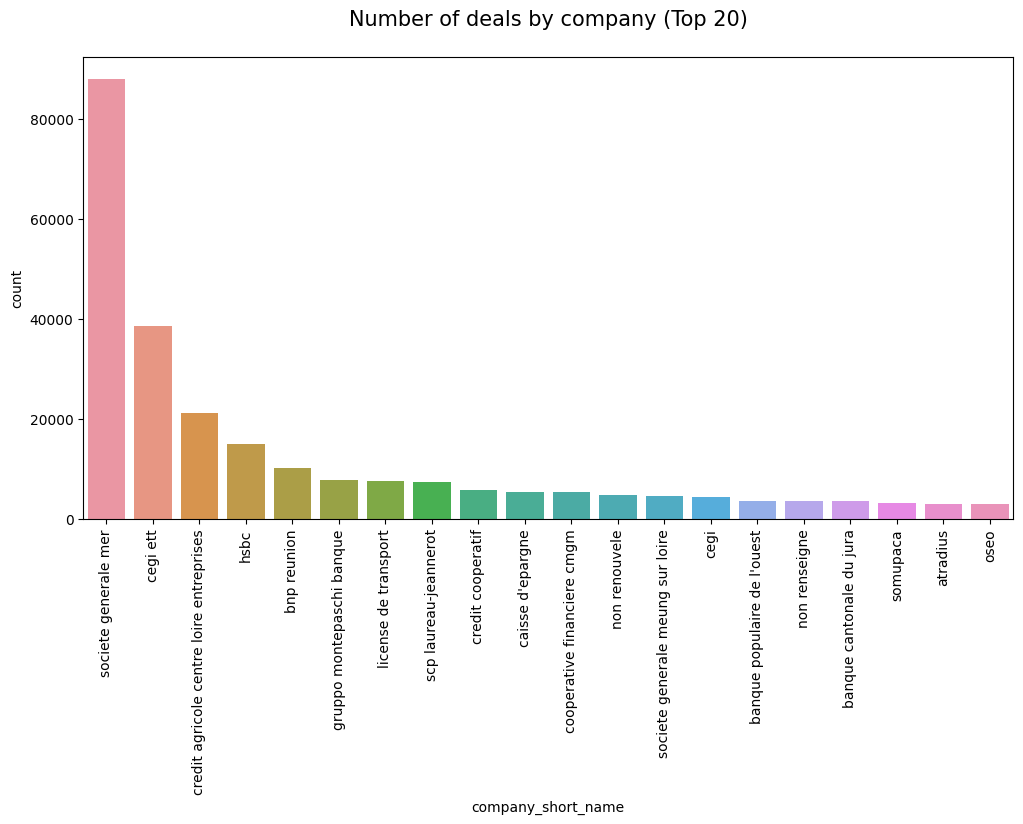

In [507]:
# Histogramme du nombre de deals par company_short_name (top 20)
plt.figure(figsize=(12, 6))
top_20_companies = df_preprocessed['company_short_name'].value_counts().head(20)
sns.countplot(x='company_short_name', data=df_preprocessed, order=top_20_companies.index)
plt.title('Number of deals by company (Top 20)\n', fontsize=15)
plt.xticks(rotation=90)
plt.show()


D. **B_Sides analysis**

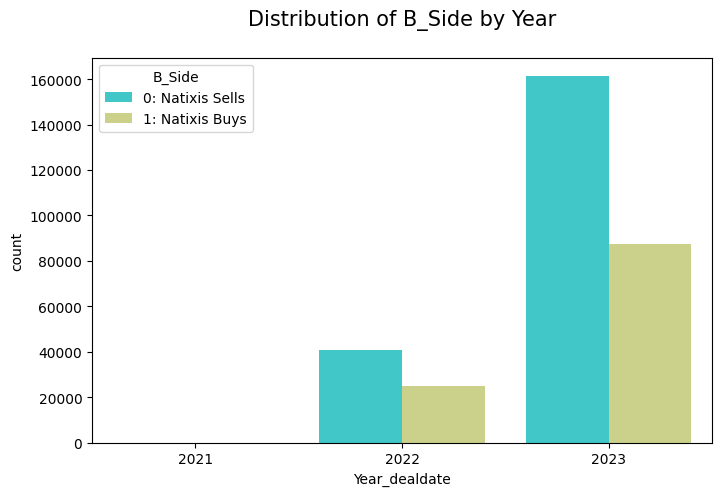

In [513]:
plt.figure(figsize=(8, 5))
palette = sns.color_palette("rainbow", n_colors=2)
sns.countplot(x='Year_dealdate', hue='B_Side', data=df_preprocessed, palette=palette)
plt.legend(title='B_Side', labels=['0: Natixis Sells', '1: Natixis Buys'])
plt.title('Distribution of B_Side by Year\n', fontsize=15)
plt.show()

E. **BloomIndustrySector analysis**

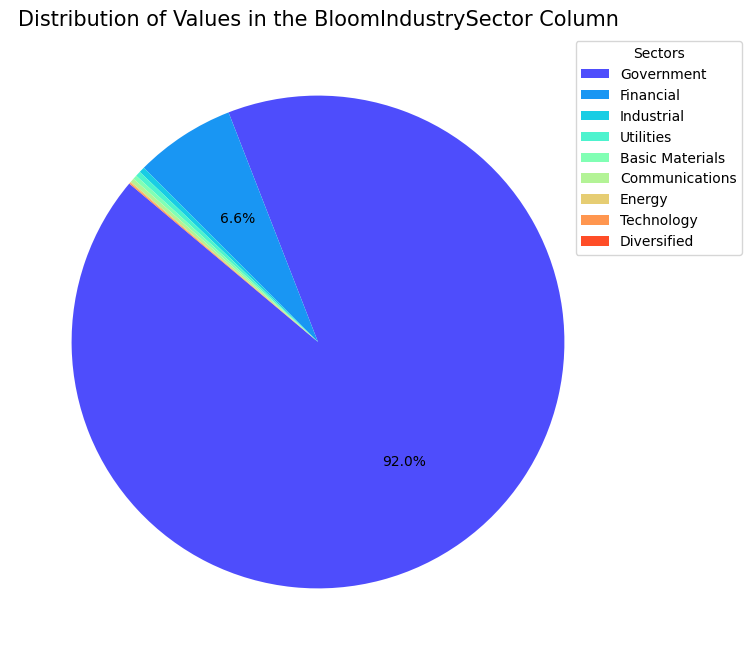

In [509]:
sector_counts = df_preprocessed['BloomIndustrySector'].value_counts()
colors = sns.color_palette('rainbow', len(sector_counts))

# Set the threshold for displaying percentages
percentage_threshold = 2
def autopct_func(pct):
    return f'{pct:.1f}%' if pct >= percentage_threshold else ''

# Plot the pie chart without labels
plt.figure(figsize=(10, 8))
plt.pie(sector_counts, labels=None, autopct=autopct_func, startangle=140, colors=colors)
plt.legend(sector_counts.index, title='Sectors', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Distribution of Values in the BloomIndustrySector Column', fontsize=15)
plt.show()


In [510]:
number_industries = len(df_preprocessed['BloomIndustryGroup'].unique())
print('Number of industries : ', number_industries)
df_preprocessed.BloomIndustryGroup.value_counts()

Number of industries :  43


BloomIndustryGroup
Sovereign                   285926
Banks                        18101
Multi-National                2823
Diversified Finan Serv        1854
Electric                       920
Regional(state/provnc)         772
Iron/Steel                     662
Telecommunications             610
Transportation                 451
Insurance                      284
Engineering&Construction       197
REITS                          196
Oil&Gas                        174
Computers                      156
Savings&Loans                  146
Miscellaneous Manufactur       130
Building Materials             117
Internet                       116
Chemicals                      106
Real Estate                    103
Water                           94
Aerospace/Defense               93
Electrical Compo&Equip          90
Environmental Control           80
Municipal                       67
Mining                          64
Gas                             59
Media                           57
P

In [511]:
number_subindustries = len(df_preprocessed['BloomIndustrySubGroup'].unique())
print('Number of sub industries : ', number_subindustries)
df_preprocessed.BloomIndustrySubGroup.value_counts()

Number of sub industries :  118


BloomIndustrySubGroup
Sovereign                   283266
Commer Banks Non-US           9320
Diversified Banking Inst      5087
Supranational Bank            2823
Sovereign Agency              2457
                             ...  
Shipbuilding                     1
Office Automation&Equip          1
Wireless Equipment               1
Insurance Brokers                1
REITS-Office Property            1
Name: count, Length: 118, dtype: int64

F. **Days_to_Maturity analysis**

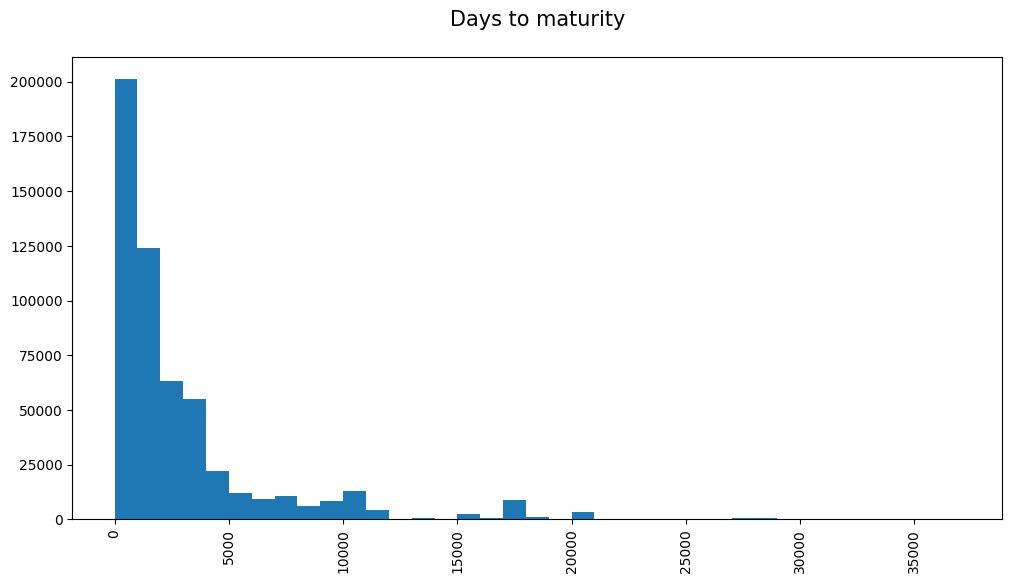

In [444]:
# Histogram of the number of deals per company_short_name (top 20) with bins of size 50
plt.figure(figsize=(12, 6))
plt.hist(df_preprocessed['Days_to_Maturity'], bins=range(0, max(df_preprocessed['Days_to_Maturity']) + 1000, 1000))
plt.title('Days to maturity\n', fontsize=15)
plt.xticks(rotation=90)
plt.show()


G. **Fitch Credit rating**

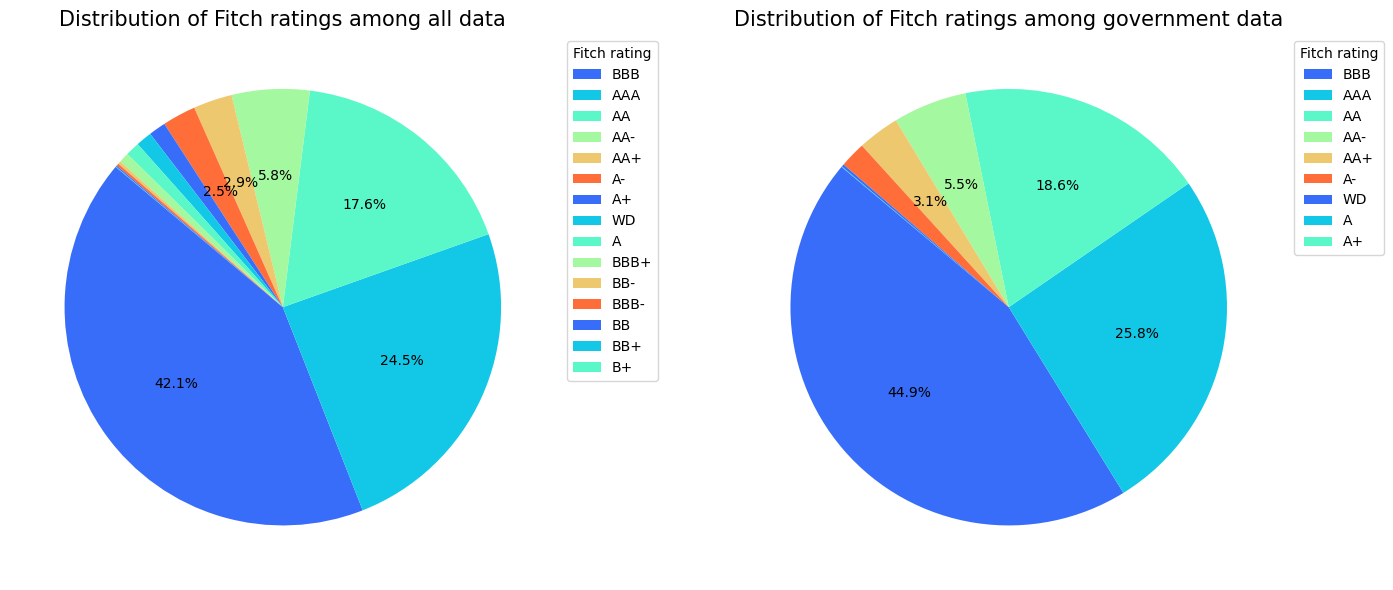

In [518]:
# Set the common attributes
colors = sns.color_palette('rainbow')
percentage_threshold = 2
autopct_func = lambda pct: f'{pct:.1f}%' if pct >= percentage_threshold else ''

# Plot the pie chart for the entire dataset
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
Fitch_counts_all = df_preprocessed['Rating_Fitch'].value_counts()
plt.pie(Fitch_counts_all, labels=None, autopct=autopct_func, startangle=140, colors=colors)
plt.legend(Fitch_counts_all.index, title='Fitch rating', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Distribution of Fitch ratings among all data', fontsize=15)

# Plot the pie chart for the government data
plt.subplot(1, 2, 2)
df_government = df_preprocessed[df_preprocessed['BloomIndustrySector']=='Government'].copy()
Fitch_counts_government = df_government['Rating_Fitch'].value_counts()
plt.pie(Fitch_counts_government, labels=None, autopct=autopct_func, startangle=140, colors=colors)
plt.legend(Fitch_counts_government.index, title='Fitch rating', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Distribution of Fitch ratings among government data', fontsize=15)

# Adjust layout
plt.tight_layout()
plt.show()


H. **Moodys Credit rating**

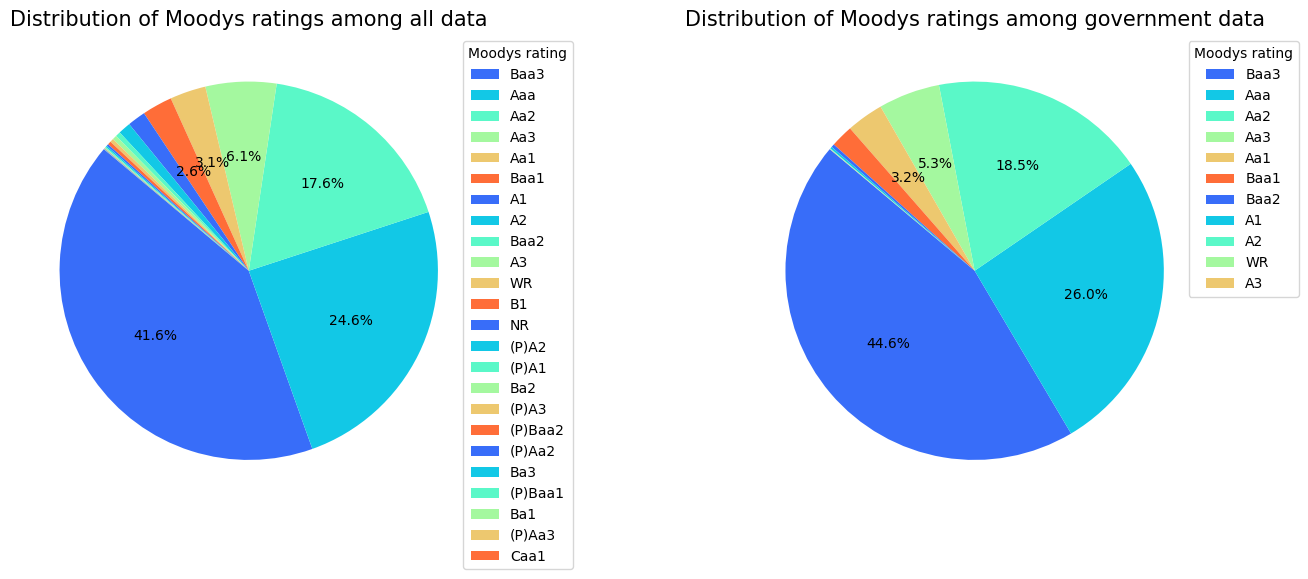

In [522]:
# Set the common attributes
colors = sns.color_palette('rainbow')
percentage_threshold = 2
autopct_func = lambda pct: f'{pct:.1f}%' if pct >= percentage_threshold else ''

# Plot the pie chart for the entire dataset
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
moodys_counts_all = df_preprocessed['Rating_Moodys'].value_counts()
plt.pie(moodys_counts_all, labels=None, autopct=autopct_func, startangle=140, colors=colors)
plt.legend(moodys_counts_all.index, title='Moodys rating', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Distribution of Moodys ratings among all data', fontsize=15)

# Plot the pie chart for the government data
plt.subplot(1, 2, 2)
df_government = df_preprocessed[df_preprocessed['BloomIndustrySector']=='Government'].copy()
moodys_counts_all = df_government['Rating_Moodys'].value_counts()
plt.pie(moodys_counts_all, labels=None, autopct=autopct_func, startangle=140, colors=colors)
plt.legend(moodys_counts_all.index, title='Moodys rating', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Distribution of Moodys ratings among government data', fontsize=15)

# Adjust layout
plt.tight_layout()
plt.show()


I. **SP Credit rating**

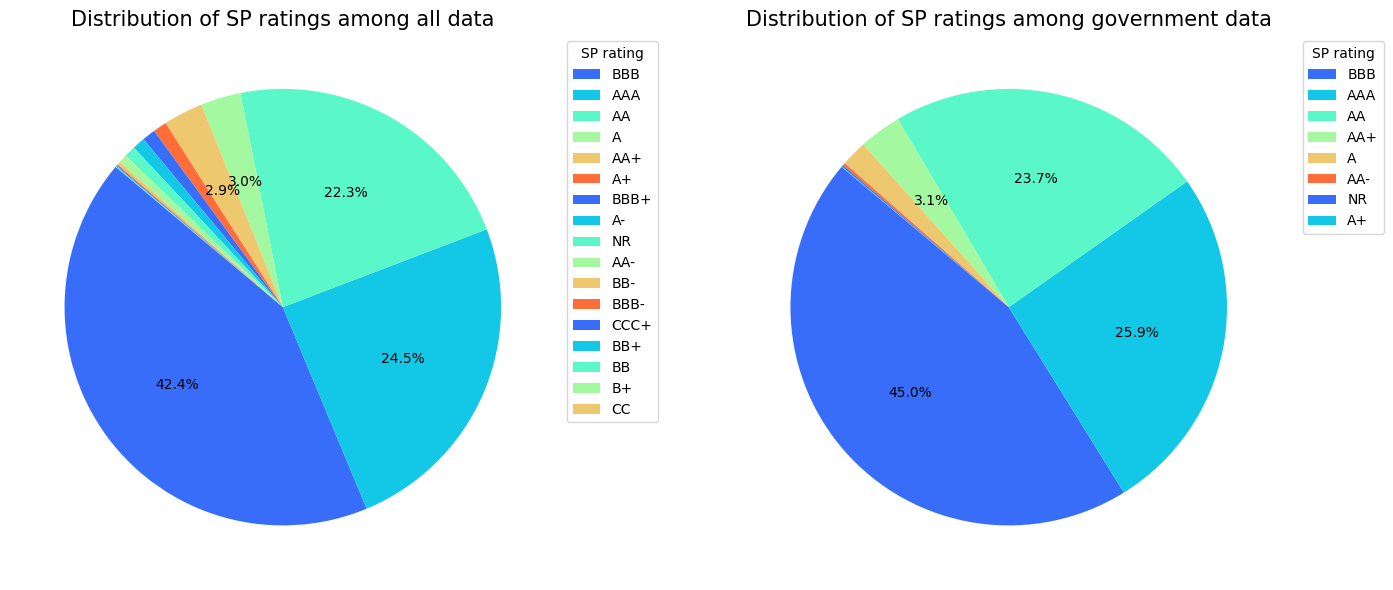

In [524]:
# Set the common attributes
colors = sns.color_palette('rainbow')
percentage_threshold = 2
autopct_func = lambda pct: f'{pct:.1f}%' if pct >= percentage_threshold else ''

# Plot the pie chart for the entire dataset
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
moodys_counts_all = df_preprocessed['Rating_SP'].value_counts()
plt.pie(moodys_counts_all, labels=None, autopct=autopct_func, startangle=140, colors=colors)
plt.legend(moodys_counts_all.index, title='SP rating', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Distribution of SP ratings among all data', fontsize=15)

# Plot the pie chart for the government data
plt.subplot(1, 2, 2)
df_government = df_preprocessed[df_preprocessed['BloomIndustrySector']=='Government'].copy()
moodys_counts_all = df_government['Rating_SP'].value_counts()
plt.pie(moodys_counts_all, labels=None, autopct=autopct_func, startangle=140, colors=colors)
plt.legend(moodys_counts_all.index, title='SP rating', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Distribution of SP ratings among government data', fontsize=15)

# Adjust layout
plt.tight_layout()
plt.show()


## Reflections on the subject

2 main questions: 
- Classify bonds by similarities. This will help us identify and select relevant characteristics (columns) from the data set that are crucial to understanding bond characteristics.
- Classify customers by similarities, based on their investment strategies/styles, such as leverage, long/short hedging, arbitrage, asset class (bonds, equities, currencies, options, futures, or warrants...).

Clustering techniques that could be used : 
- K-means clustering
- hierarchical clustering
- Fuzzy C-mean Clustering (FCM)
- Self-Organizing Map (SOM) neural network technique
- Expectation Maximization clustering (EM)


In [525]:
from sklearn.preprocessing import StandardScaler

# Select columns for k-means
kmeans_columns = ['Coupon', 'Frequency', 'BloomIndustrySector', 'Days_to_Maturity', 'Type', 'MidPrice']
df_kmeans = df_preprocessed[kmeans_columns]
df_kmeans.dropna(inplace=True)

# Encode categorical columns
label_encoder = LabelEncoder()
columns_to_encode = ['BloomIndustrySector', 'Type']
for column in columns_to_encode:
    df_kmeans[column] = label_encoder.fit_transform(df_kmeans[column])

# Scale the features
scaler = StandardScaler()
df_kmeans_scaled = pd.DataFrame(scaler.fit_transform(df_kmeans), columns=df_kmeans.columns)

df_kmeans_scaled.head()


/var/folders/h7/_dgsjjs93hv7lr5ql2ffz2_c0000gn/T/ipykernel_71306/84491845.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans.dropna(inplace=True)
/var/folders/h7/_dgsjjs93hv7lr5ql2ffz2_c0000gn/T/ipykernel_71306/84491845.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans[column] = label_encoder.fit_transform(df_kmeans[column])
/var/folders/h7/_dgsjjs93hv7lr5ql2ffz2_c0000gn/T/ipykernel_71306/84491845.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

,Coupon,Frequency,BloomIndustrySector,Days_to_Maturity,Type,MidPrice
0,-1.022784,0.775485,0.16554,-0.626193,-0.094426,0.258391
1,-1.022784,0.775485,0.16554,-0.626193,-0.094426,0.258391
2,-1.022784,0.775485,0.16554,-0.626193,-0.094426,0.258391
3,-1.022784,0.775485,0.16554,-0.626193,-0.094426,0.258391
4,1.525422,-1.289149,0.16554,0.959052,-0.094426,-0.108647


In [526]:
from sklearn.cluster import KMeans

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_kmeans['Cluster'] = kmeans.fit_predict(df_kmeans)

/Users/vitrac/Library/Python/3.8/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/h7/_dgsjjs93hv7lr5ql2ffz2_c0000gn/T/ipykernel_71306/2929666551.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans['Cluster'] = kmeans.fit_predict(df_kmeans)


In [527]:
df_kmeans.Cluster.value_counts()

Cluster
1    240905
0     61254
2     12526
Name: count, dtype: int64